#  Initialize KAN

In [1]:
from kan import *
import torch
torch.manual_seed(24)

# Create dataset

In [2]:
dataset = {}
train_input = np.linspace(0.2, 4, 100).reshape(-1, 1)
test_input = np.linspace(0,3, 100).reshape(-1, 1)
dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)

dataset['train_label'] = torch.zeros(train_input.shape[0], 1)  
dataset['test_label'] = torch.ones(test_input.shape[0], 1)   

# define the train function

In [3]:
# 创建一个 KAN：第一层是两个特征输入层节点（x, y），第二层是 5 个隐藏层节点，第三层是 1 个输出层节点 f(x, y)，k = 3 代表选择三次样条曲线，grid = 5 代表网格点为 5
model = KAN(width=[1,3,1], grid=5, k=3, seed=1, noise_scale_base = 2., noise_scale = 0.)
# x = torch.normal(1,10,size=(1000,1))
# model.update_grid_from_samples(x)

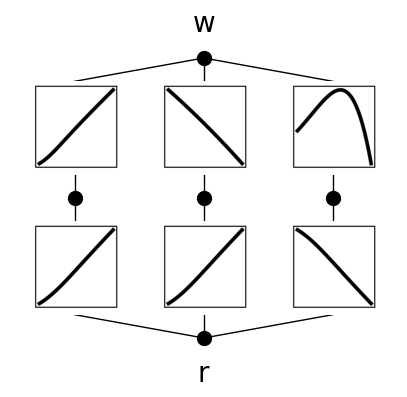

In [4]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100,in_vars=['r'], out_vars=['w'])

In [5]:
# model.fix_symbolic(2,0,0,'sigmoid')
# model.fix_symbolic(0,0,0,'sigmoid')
# model.fix_symbolic(1,0,0,'sigmoid')
# model.fix_symbolic(3,0,0,'exp')

In [6]:
def KAN_train(self, dataset, func_LE, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(-1, )
            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # Regularize coefficient to encourage spline to be zero
        for i in range(len(self.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(self.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(self.act_fun[i].coef)), dim=1))
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn is None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean(torch.abs(x - y))
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    # 将 g 定义为可训练的张量
    g = torch.tensor(0.2, requires_grad=True, device=device)

    # 将 g 添加到优化器中
    if opt == "Adam":
        optimizer = torch.optim.Adam(list(self.parameters()) + [g], lr=lr)  # 将 g 作为单独的参数
    elif opt == "LBFGS":
        optimizer = LBFGS([*self.parameters(), g], lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['test_loss'] = []
    results['reg'] = []
    results['g_values'] = []  # 用于存储 g 的值
    if metrics is not None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_test = dataset['test_input'].shape[0]
    else:
        batch_size = batch
        batch_size_test = batch

    global train_loss, reg_

    def custom_loss(w_rn, w_r0):
        penalty = torch.where(w_rn <= w_r0, (w_r0 - w_rn) * 10, torch.tensor(0.0, device=w_rn.device))
        penalty_sum = torch.sum(penalty)
        total_loss = penalty_sum  # + base_loss 
        return total_loss

    
    def closure():
        global train_loss, reg_

        optimizer.zero_grad()
        
        loss2_accum = 0.0  # Initialize accumulated loss
        r_min = 0.01
        deg = 150
        xk, wk = np.polynomial.legendre.leggauss(deg)
        xk = torch.from_numpy(xk).float().to(device)
        wk = torch.from_numpy(wk).float().to(device)

        r = dataset['train_input'].to(device)
        r.requires_grad = True

        L_dis = torch.tensor([], device=device)
        m1 = torch.tensor([], device=device)

        for idx in range(len(r)):
            xn = (r[idx] - r_min) * 0.5 * xk + (r[idx] + r_min) * 0.5
            wn = wk * (r[idx] - r_min) * 0.5

            xn = xn.reshape(-1, 1).to(device)
            wn = wn.reshape(-1, 1).to(device)

            x_fn = self.forward(xn)
            w_rn = x_fn / xn ** 2
            hn = torch.tensor([0.0], requires_grad=True, device=device, dtype=torch.double).reshape(-1, 1).to(device)
            x_fn0 = self.forward(hn)
            x_fn0d = torch.autograd.grad(outputs=x_fn0, inputs=hn, create_graph=True)[0]
            w_r0 = self.forward(r[idx].reshape(-1, 1).to(device)) / r[idx] ** 2
        
            current_loss2 = custom_loss(w_rn, w_r0)
            loss2_accum += current_loss2

            diff = w_rn ** 2 - w_r0 ** 2
            mask = diff <= 0
            if torch.any(diff <= 0):
                print("错误！小于0")

            diff[mask] = 100
            Inter1 = 2 * 0.1973 * wn * (w_r0 ** 2 / diff) ** 0.5
            Inter2 = wn * w_rn * (1 + w_r0 ** 2 / diff) ** 0.5 - wn * x_fn0 / xn ** 2 - wn * x_fn0d / xn 

            p1 = torch.sum(Inter1)
            p2 = torch.sum(Inter2)

            p1 = p1.reshape(-1, 1)
            p2 = p2.reshape(-1, 1)

            L_dis = torch.cat((L_dis, p1), 0)
            m1 = torch.cat((m1, p2), 0)

        HQ_pred = 2 * g * m1 - 2 * g * x_fn0 / r + 2*g* x_fn0d*torch.log(r)
        HQ_true = func_LE(L_dis.detach().cpu().numpy())
        HQ_true = torch.FloatTensor(HQ_true).reshape(-1, 1).to(device)
        
        train_loss = loss_fn(HQ_pred, HQ_true)
        constraint_loss = (x_fn0 - 1.0) ** 2 
        loss2 = loss2_accum
        
        #print("xn", xn)
        #print("x_fn", x_fn)
        print("train_loss==", train_loss)
        print("g", g)
        reg_ = reg(self.acts_scale)
        objective = train_loss + lamb * reg_ + loss2 + constraint_loss * 10 # 将 g 加入目标函数以便更新
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)

    for _ in pbar:
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)
        if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
            self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            reg_ = reg(self.acts_scale)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))
        if _ % log == 0:
            pbar.set_description("train loss: %.2e |  reg: %.2e " % (train_loss.cpu().detach().numpy(), reg_.cpu().detach().numpy()))

        results['g_values'].append(g.item())  # 保存 g 的值


In [7]:
KAN.KAN_train = KAN_train

In [8]:
def func_LE_wrapper(L):
    E =0.8404*L - 0.0866/L +0.1033
    return E

In [9]:
model.KAN_train(dataset,func_LE_wrapper, steps=2, lamb=0.01,lamb_entropy=5.0,lr=2);

description:   0%|                                                            | 0/2 [00:00<?, ?it/s]d:\Jupyter\两味道T=0Mev\pykan-master\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


train_loss== tensor(0.1168, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2000, requires_grad=True)
train_loss== tensor(0.3345, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2139, requires_grad=True)
train_loss== tensor(0.1178, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2042, requires_grad=True)
train_loss== tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2128, requires_grad=True)
train_loss== tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2178, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2164, requires_grad=True)
train_loss== tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2157, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
t

train loss: 3.81e-02 |  reg: 9.49e+00 :  50%|████████████            | 1/2 [04:07<04:07, 247.14s/it]

train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
train_loss== tensor(0.0894, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2070, requires_grad=True)
train_loss== tensor(0.0402, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2138, requires_grad=True)
train_loss== tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2157, requires_grad=True)
train_loss== tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2162, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
train_loss== tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2163, requires_grad=True)
t

train loss: 3.81e-02 |  reg: 9.49e+00 : 100%|████████████████████████| 2/2 [07:09<00:00, 214.82s/it]


In [10]:
model.save_ckpt('ckpt1')

save this model to ./model_ckpt/ckpt1


# Obtain the symbolic formula

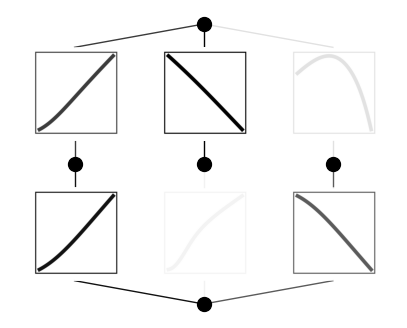

In [11]:
model.plot()
# model.save_ckpt('ckpt1')

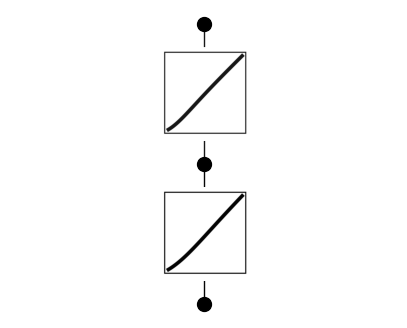

In [12]:
model = model.prune(0.1)
model(dataset['train_input'])
model.plot()

In [13]:
model.KAN_train(dataset,func_LE_wrapper, steps=2, lamb=0.01,lamb_entropy=5.0,lr=2);

description:   0%|                                                            | 0/2 [00:00<?, ?it/s]

train_loss== tensor(0.1602, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2000, requires_grad=True)
train_loss== tensor(0.4171, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.0842, requires_grad=True)
train_loss== tensor(0.1263, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2289, requires_grad=True)
train_loss== tensor(0.1361, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.1669, requires_grad=True)
train_loss== tensor(0.7190, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.3771, requires_grad=True)
train_loss== tensor(0.0557, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2041, requires_grad=True)
train_loss== tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2021, requires_grad=True)
train_loss== tensor(0.0500, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2035, requires_grad=True)
train_loss== tensor(0.0457, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2029, requires_grad=True)
t

train loss: 3.73e-02 |  reg: 2.69e+00 :  50%|████████████            | 1/2 [02:25<02:25, 145.08s/it]

train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
train_loss== tensor(0.0427, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2418, requires_grad=True)
train_loss== tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2264, requires_grad=True)
train_loss== tensor(0.0374, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2244, requires_grad=True)
train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
train_loss== tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2240, requires_grad=True)
t

train loss: 3.73e-02 |  reg: 2.69e+00 : 100%|████████████████████████| 2/2 [05:14<00:00, 157.00s/it]


fixing (0,0,0) with sin, r2=0.9999745781495012
fixing (1,0,0) with sin, r2=0.9999284042375572


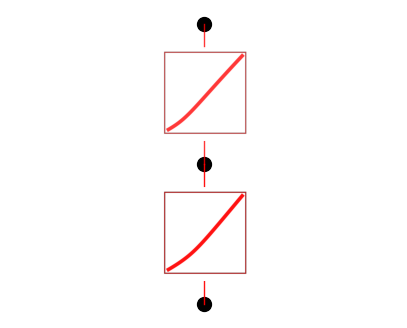

In [14]:
model.auto_symbolic()
model.plot()

In [15]:
model.KAN_train(dataset,func_LE_wrapper, steps=1, lamb=0.01,lamb_entropy=5.0,lr=1);

description:   0%|                                                            | 0/1 [00:00<?, ?it/s]d:\Jupyter\两味道T=0Mev\pykan-master\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


train_loss== tensor(0.0530, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2000, requires_grad=True)
train_loss== tensor(3.0629, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.8562, requires_grad=True)
train_loss== tensor(0.1412, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2431, requires_grad=True)
train_loss== tensor(0.0448, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2067, requires_grad=True)
train_loss== tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2137, requires_grad=True)
train_loss== tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2526, requires_grad=True)
train_loss== tensor(0.0501, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2833, requires_grad=True)
train_loss== tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2573, requires_grad=True)
train_loss== tensor(0.0388, dtype=torch.float64, grad_fn=<MeanBackward0>)
g tensor(0.2702, requires_grad=True)
t

train loss: 3.28e-02 |  reg: 2.42e+00 : 100%|█████████████████████████| 1/1 [01:27<00:00, 87.61s/it]


In [16]:
model.symbolic_formula()[0][0]

2.94*sin(1.24*sin(0.47*x_1 + 1.94) - 9.55) + 3.53

In [17]:
model.symbolic_formula(var=['r'])[0]

[2.94*sin(1.24*sin(0.47*r + 1.94) - 9.55) + 3.53]

train loss: 6.35e-09 | test loss: 1.00e+00 | reg: 2.69e+02 : 100%|██| 50/50 [00:08<00:00,  6.17it/s]


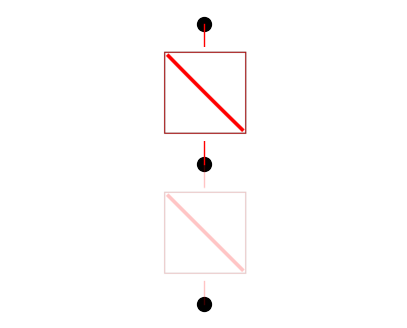

In [17]:
model.train(dataset, opt="LBFGS", steps=50);
model.plot()

In [18]:
model.load_ckpt('ckpt1')

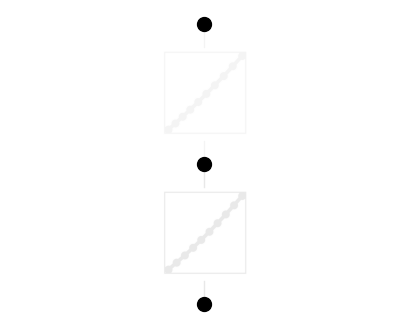

In [19]:
model(dataset['train_input'][:10])
model.plot(sample=True)